# Llama from scratch (or how to implement a paper without crying)

## Setting up our dataset

In [39]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

In [40]:
lines = open('./data/Shakespeare.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [41]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [42]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [43]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [44]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('crooked age,\nTo ', 'rooked age,\nTo c'),
 ('ng,--\n\nAUFIDIUS:', 'g,--\n\nAUFIDIUS:\n'),
 ('en her hence to ', 'n her hence to m'),
 ('n were I painted', ' were I painted '),
 (' it.\n\nFirst Murd', 'it.\n\nFirst Murde'),
 ('her mocks both y', 'er mocks both yo'),
 ('ce I have set my', 'e I have set my '),
 ('t;\nAnd craves yo', ';\nAnd craves you')]

## Evaluation

In [45]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## Setting up a working base model

In [46]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)
        # logits = F.softmax(a, dim=-1)

        # print(logits.view(-1, self.config['vocab_size']).shape)
        # print(targets.view(-1).shape)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 33217


model params: 33217
validation loss:  2.5156085014343263


<Axes: >

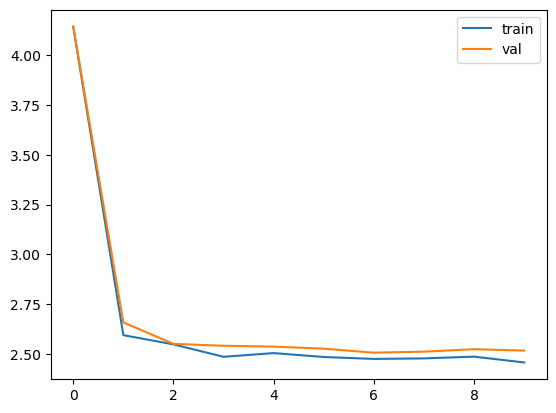

In [47]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 100,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    # print(pd.DataFrame(losses))
    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

In [48]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        # logits = model(idx[:, -1:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    
    return [decode(x) for x in idx.tolist()]

generate(model)

['\n\nTifes fout d, an hte, te wion',
 '\nMORGHAy cy alco k, mem rberr t',
 '\nBull winoosthioman nghe hest, ',
 '\nCoure;\nFo chon, f w s t t.\n\nWA',
 "\nUERCLen'd, he pry hed t for\nWh"]

## Llama specifics

### RMSNorm

In [49]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        # self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
        self.scale = nn.Parameter(torch.ones(layer_shape))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw # todo: self.scale[:x.shape[1], :] -> self.scale

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


#### Test

In [50]:
# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

#### SimpleModel_RMS

model params: 35265
validation loss:  2.5261898756027223


<Axes: >

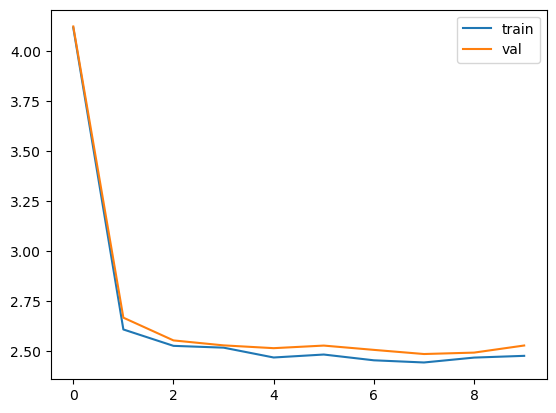

In [51]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

### Rotary Embeddings

In [52]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

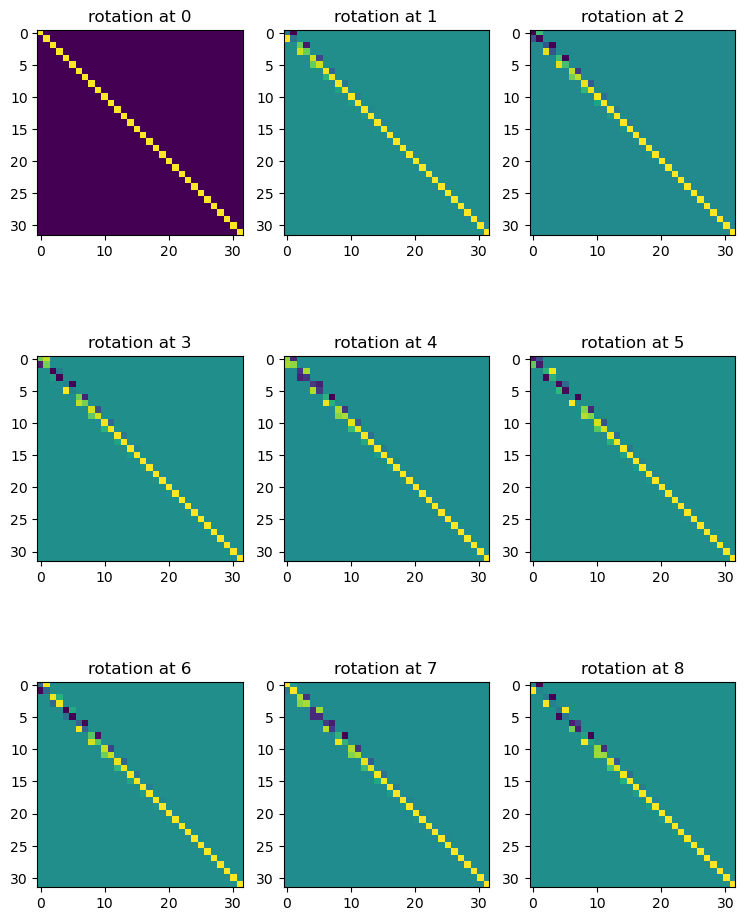

In [53]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

#### Test

In [54]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

#### RoPEAttentionHead

In [55]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p =.1, is_causal=True
        )
        

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            # print(torch.exp(attn_weights[1][0])/torch.exp(attn_weights[1][0]).sum())
            attn_weights = F.softmax(attn_weights, dim=-1)
            # print(attn_weights[1][0])
            return activations, attn_weights
        return activations

layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

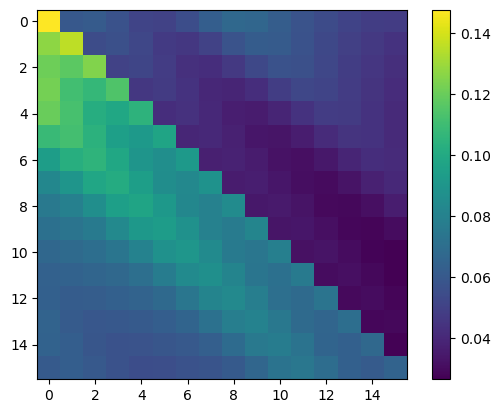

In [56]:
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [57]:
# Attention Implementation

batch_size, context_length, embedding_size = 32, 64, 128

x = torch.randn((batch_size, context_length, embedding_size))
W_q = torch.randn((embedding_size, embedding_size))
W_k = torch.randn((embedding_size, embedding_size))
W_v = torch.randn((embedding_size, embedding_size))

q = x @ W_q
k = x @ W_k
v = x @ W_v
attn_weights = (q @ k.transpose(1,2)) / np.sqrt(embedding_size)
activations = attn_weights @ v
activations.shape

torch.Size([32, 64, 128])

#### Multi-Head

In [58]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

In [59]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())

model params: 559681


Epoch 0 | val loss 4.064 | Time 0.047 | ETA in seconds 2.366
Epoch 100 | val loss 2.436 | Time 1.765 | ETA in seconds 86.505
Epoch 200 | val loss 2.326 | Time 1.816 | ETA in seconds 87.174
Epoch 300 | val loss 2.276 | Time 1.776 | ETA in seconds 83.451
Epoch 400 | val loss 2.200 | Time 1.862 | ETA in seconds 85.656
Epoch 500 | val loss 2.163 | Time 1.724 | ETA in seconds 77.600
Epoch 600 | val loss 2.168 | Time 2.179 | ETA in seconds 95.883
Epoch 700 | val loss 2.112 | Time 3.538 | ETA in seconds 152.118
Epoch 800 | val loss 2.096 | Time 3.940 | ETA in seconds 165.497
Epoch 900 | val loss 2.103 | Time 5.402 | ETA in seconds 221.484
Epoch 1000 | val loss 2.062 | Time 4.053 | ETA in seconds 162.117
Epoch 1100 | val loss 2.088 | Time 3.971 | ETA in seconds 154.877
Epoch 1200 | val loss 2.082 | Time 4.085 | ETA in seconds 155.229
Epoch 1300 | val loss 2.049 | Time 4.274 | ETA in seconds 158.128
Epoch 1400 | val loss 2.052 | Time 4.149 | ETA in seconds 149.376
Epoch 1500 | val loss 2.098 | 

<Axes: >

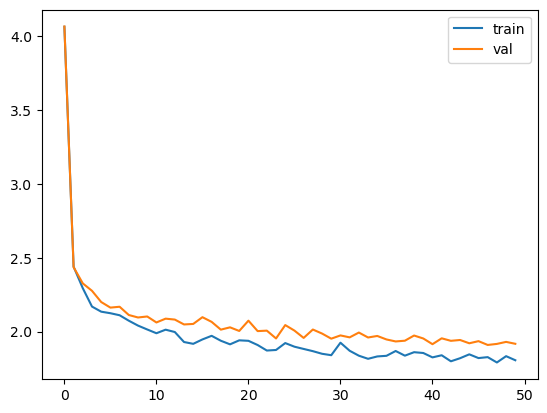

In [60]:
MASTER_CONFIG.update({
    "epochs": 5000,
})
train(model, optimizer,print_logs=True)

In [61]:
generate(model, config=MASTER_CONFIG)

['\nTo be the hofserven like me op',
 '\nBe the sto that I am the sorip',
 '\nThe to ratry! disdencerve the ',
 '\nAnd proye he pray,\nUnchas bot ',
 '\nWhat give dispure: joy hammno ']

## SwiGLU

In [62]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        # self.beta = torch.randn(1, requires_grad=True)

        self.beta = torch.ones(1, requires_grad=True)
        # nn.Parameter(torch.ones(1))
        # self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 592705
Epoch 0 | val loss 4.108 | Time 0.098 | ETA in seconds 4.917
Epoch 100 | val loss 2.484 | Time 4.403 | ETA in seconds 215.746
Epoch 200 | val loss 2.314 | Time 5.015 | ETA in seconds 240.716
Epoch 300 | val loss 2.259 | Time 4.817 | ETA in seconds 226.421
Epoch 400 | val loss 2.178 | Time 5.136 | ETA in seconds 236.279
Epoch 500 | val loss 2.144 | Time 9.155 | ETA in seconds 411.994
Epoch 600 | val loss 2.139 | Time 5.025 | ETA in seconds 221.120
Epoch 700 | val loss 2.124 | Time 4.751 | ETA in seconds 204.286
Epoch 800 | val loss 2.100 | Time 4.655 | ETA in seconds 195.515
Epoch 900 | val loss 2.094 | Time 4.801 | ETA in seconds 196.846
Epoch 1000 | val loss 2.075 | Time 4.253 | ETA in seconds 170.128
Epoch 1100 | val loss 2.035 | Time 4.270 | ETA in seconds 166.512
Epoch 1200 | val loss 2.064 | Time 4.545 | ETA in seconds 172.727
Epoch 1300 | val loss 2.066 | Time 5.992 | ETA in seconds 221.707
Epoch 1400 | val loss 2.028 | Time 4.659 | ETA in seconds 167.730
Epo

<Axes: >

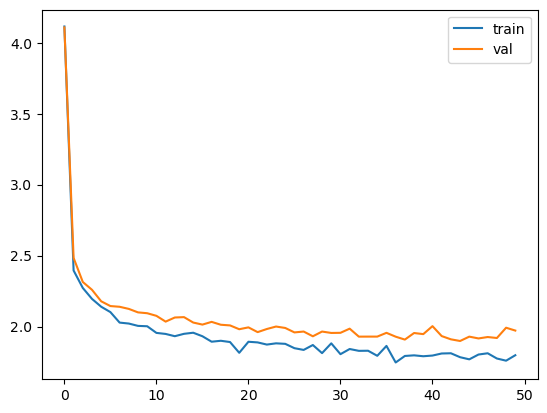

In [63]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer, print_logs=True)

In [64]:
generate(model, config=MASTER_CONFIG)

['\nBut his life, do my lal to it ',
 "\n' seve all did, and:\nSecar, bu",
 '\nIf you have it the pare bow, I',
 '\nBerd be not ithous bower.\n\nWAR',
 '\nShould dur oveere magane that ']

## Final LLaMa

In [65]:
from collections import OrderedDict

# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 2370241
Epoch 0 | val loss 4.158 | Time 0.317 | ETA in seconds 31.687
Epoch 100 | val loss 2.494 | Time 16.497 | ETA in seconds 1633.155
Epoch 200 | val loss 2.315 | Time 15.908 | ETA in seconds 1558.937
Epoch 300 | val loss 2.127 | Time 15.434 | ETA in seconds 1497.142
Epoch 400 | val loss 2.092 | Time 16.834 | ETA in seconds 1616.095
Epoch 500 | val loss 2.058 | Time 16.567 | ETA in seconds 1573.836
Epoch 600 | val loss 2.049 | Time 15.025 | ETA in seconds 1412.326
Epoch 700 | val loss 2.009 | Time 15.861 | ETA in seconds 1475.074
Epoch 800 | val loss 1.965 | Time 15.719 | ETA in seconds 1446.167
Epoch 900 | val loss 1.981 | Time 15.405 | ETA in seconds 1401.860
Epoch 1000 | val loss 1.939 | Time 16.907 | ETA in seconds 1521.655
Epoch 1100 | val loss 1.872 | Time 15.854 | ETA in seconds 1410.992
Epoch 1200 | val loss 1.878 | Time 16.269 | ETA in seconds 1431.632
Epoch 1300 | val loss 1.909 | Time 15.358 | ETA in seconds 1336.168
Epoch 1400 | val loss 1.867 | Time 15.118

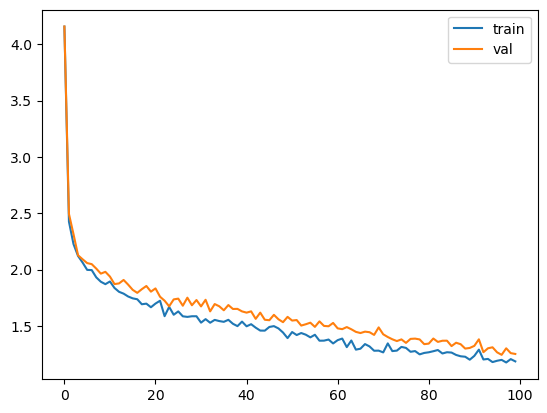

In [66]:
MASTER_CONFIG.update({
    'epochs': 10000,
    'batch_size': 32,
    'd_model': 128,
    'n_heads': 8,
    'n_layers': 4,
    'context_window': 16,
    "log_interval": 100,
})

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG,print_logs=True)

print(generate(llama, MASTER_CONFIG, 500)[0])
torch.save({'model_state_dict': llama.state_dict()}, "./checkpoint/llama.pth")

In [67]:
llama_infer = Llama(MASTER_CONFIG)
checkpoint = torch.load("./checkpoint/llama.pth")
llama_infer.load_state_dict(checkpoint['model_state_dict'])
print(generate(llama_infer, MASTER_CONFIG, 500)[0])

model params: 2370241

MENELIUS:
Name, let's pers,
Two have by han listring have lishandsleds shilelither,
That ownle that rist; yet my face em for some come, suchackly off.
Chand an his pen way: part;
Take an unscondangeral,
Will due'll ray, toing wind your in bemide?

EcKENENIUS:
Mild; so harrow;
Starding brooth know, and away.
Thus not stay this rightle my theings fill's time Richard my he men of him
Yethan of foul hand, of quarnisint. Has undiffinct yours that come do; fire half thou god when at omper not your bis


#### Test

In [68]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = llama(xs, ys)

print(loss)

tensor(1.4658, grad_fn=<NllLossBackward0>)


## Miscellaneous

### Check for Gradient Flows

In [69]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.llama_3.attention.linear.weight', 24.24163818359375),
 ('llama_blocks.llama_2.attention.linear.weight', 22.3663330078125),
 ('llama_blocks.llama_0.attention.linear.weight', 21.83685302734375),
 ('llama_blocks.llama_1.attention.linear.weight', 19.690704345703125),
 ('llama_blocks.llama_3.attention.heads.5.w_v.weight', 19.476318359375),
 ('llama_blocks.llama_3.attention.heads.4.w_v.weight', 19.464111328125),
 ('llama_blocks.llama_3.attention.heads.0.w_v.weight', 18.212890625),
 ('llama_blocks.llama_3.attention.heads.7.w_v.weight', 17.7001953125),
 ('llama_blocks.llama_3.attention.heads.3.w_v.weight', 17.4560546875),
 ('llama_blocks.llama_3.attention.heads.2.w_v.weight', 16.705322265625),
 ('llama_blocks.llama_2.attention.heads.1.w_v.weight', 16.50390625),
 ('llama_blocks.llama_3.attention.heads.6.w_v.weight', 16.40625),
 ('llama_blocks.llama_3.attention.heads.1.w_v.weight', 16.265869140625),
 ('llama_blocks.llama_2.attention.heads.3.w_v.weight', 16.2109375),
 ('llama_bloc

### Experiment with hyperparams

model params: 2370241


/home/simon/anaconda3/envs/dl-fundamentals/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr:  [0.0009999457184159408]
lr:  [0.0007435220208394261]
lr:  [0.0002486299281339155]
lr:  [1.0054282328142978e-05]
lr:  [0.000266587198202317]
lr:  [0.0007614779781684484]
lr:  [0.0009999457184159232]
lr:  [0.0007435220208394129]
lr:  [0.00024862992813391206]
lr:  [1.0054282328142978e-05]
validation loss:  4.195873212814331


<Axes: >

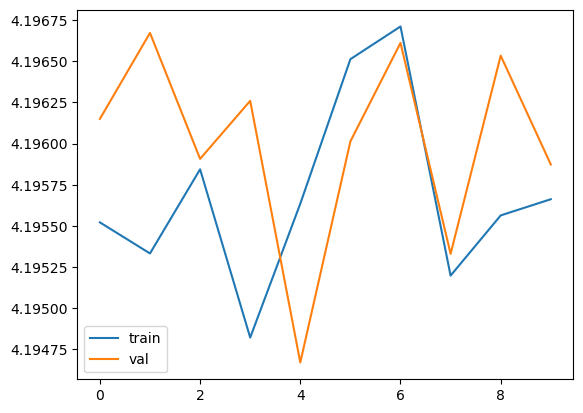

In [70]:
MASTER_CONFIG.update({
    "epochs": 1000
})
llama_with_cosine = Llama(MASTER_CONFIG)
llama_optimizer = torch.optim.Adam(
    llama.parameters(), 
    betas=(.9, .95), 
    weight_decay=.1, 
    eps=1e-9, 
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [71]:
show_grads(llama_with_cosine, 1e-5)

[('ffn.1.linear.bias', 0.78125),
 ('llama_blocks.llama_2.attention.linear.weight', 0.04119873046875),
 ('llama_blocks.llama_0.attention.heads.1.w_q.weight', 0.03662109375),
 ('llama_blocks.llama_0.attention.heads.2.w_v.weight', 0.03662109375),
 ('llama_blocks.llama_0.attention.linear.weight', 0.0335693359375),
 ('llama_blocks.llama_1.attention.heads.5.w_v.weight', 0.030517578125),
 ('llama_blocks.llama_1.attention.linear.weight', 0.030517578125),
 ('llama_blocks.llama_2.attention.heads.5.w_v.weight', 0.030517578125),
 ('llama_blocks.llama_2.attention.heads.7.w_v.weight', 0.030517578125),
 ('llama_blocks.llama_3.attention.linear.weight', 0.030517578125),
 ('llama_blocks.llama_0.attention.heads.0.w_q.weight', 0.0244140625),
 ('llama_blocks.llama_0.attention.heads.3.w_k.weight', 0.0244140625),
 ('llama_blocks.llama_1.attention.heads.6.w_v.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.heads.1.w_k.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.heads.4.w_q.weight', 0.0